# On-policy Prediction with Approximation 

In [1]:
import matplotlib
%matplotlib inline

import gym
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import sklearn.pipeline
import sklearn.preprocessing
import pdb

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

env.seed(42)

[2017-03-10 00:08:11,202] Making new env: MountainCar-v0


[42L]

In [3]:
# based on https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

n_components = 5

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=5, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=5, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=5, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=5, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0].reshape(n_components*4,1)

def getTDerror(r, gamma, theta, phi, phi1):
        
    delta = r+gamma*np.dot(theta.T,phi1)-np.dot(theta.T,phi)
    return delta
    
def policy_prob(phi, thetas_sarsa, epsilon=0.1, nA=3):
    prob = np.ones(nA) * epsilon / (nA-1)
    values = np.array([np.dot(phi.T, t) for t in thetas_sarsa])
    idx = np.argmax(values)
    prob[idx] = 1-epsilon
    return prob
       

# Episodic Semi-gradient Sarsa for Control

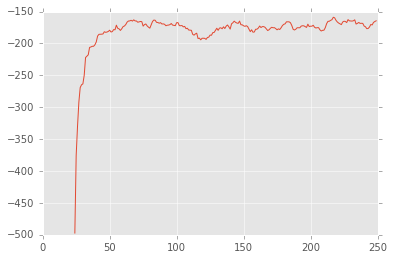

In [5]:
thetas_sarsa = []
for _ in range(env.action_space.n):
    thetas_sarsa.append(np.zeros((n_components*4,1)))

gamma = 0.99
nb_episodes = 250

rewards = np.zeros(nb_episodes)
alpha = 0.0125

for i in range(nb_episodes):
    
    s = env.reset()
    phi=featurize_state(s)
    action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n)
    a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
    r_tot = 0
    
    for steps in itertools.count():

        s1,r,done,_ = env.step(a)
        
        r_tot += r
        
        if done:
            thetas_sarsa[a] += alpha*(r-np.dot(phi.T, thetas_sarsa[a]))*phi
            break
            
        phi1 = featurize_state(s1)
        
        action_probs = policy_prob(phi1, thetas_sarsa, nA=env.action_space.n)
        a1 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        delta = r+gamma*np.dot(phi1.T, thetas_sarsa[a1]) - np.dot(phi.T, thetas_sarsa[a])
        thetas_sarsa[a] += alpha*delta*phi
        
        a,phi = a1,phi1
        

    rewards[i] = r_tot
    
    if i%100 == 0:
        alpha /= 2

plt.plot(pd.rolling_mean(rewards, 25)) 

# Linear Value-Function Approximation

We want to learn a linear approximation to estimate the state-value function for a given policy. 

\begin{eqnarray}
\theta^T \phi_s  &=& V_\theta(s)\\
&\approx& V_\pi (s)
\end{eqnarray}

where $\phi_s \in R^n$ is the feature vector. Note that $\nabla V_\theta(s) = \phi_s$.

## Linear TD(0)

Using the Mean Squared Error as an objective function:

\begin{eqnarray}
MSE(\theta) &=&  \sum_{s \in S} [V_\pi(s) - \theta^T \phi_s]^2
\end{eqnarray}

The updates are:

\begin{eqnarray}
\delta_k &=& r_k + \gamma \theta^T_k \phi'_k - \theta^T_k \phi_k \\
\theta_{k+1} &=& \theta_k + \alpha_k \delta_k \phi_k
\end{eqnarray}

## Fixed Point

In the steady state,

\begin{eqnarray}
E[\theta_{t+1}|\theta_t] &=& \theta_t + \alpha(b-A\theta_t)
\end{eqnarray}

where $A=E[\phi_t(\phi_t-\gamma\phi_{t+1})^T]$ and $b=E[R_{t+1}\phi_t]$.

It can be shown, that the TD fixpoint is

\begin{eqnarray}
b - A \theta_{TD} &=& 0 \\
\theta_{TD} &=& A^{-1}b
\end{eqnarray}


## LSTD

Estimate $A$ and $b$ to compute the fixpoint:

\begin{eqnarray}
\theta_n &=& \hat{A}^{-1}_n \hat{b}_n
\end{eqnarray}

where $\hat{A}_t = \sum_{k=1}^t \phi_k (\phi_k-\gamma \phi_{k+1})^T + \epsilon I$ (for invertibility)  and $\hat{b}_n= \frac{1}{n} \sum_{t=0}^{n-1} R_{t+1} \phi_t$

Using the Sherman-Morrison formula, the complexity is $O(n^2)$ (does not require to invert $A$), where $n$ is the number of feature used

In [13]:
def getMSPBE(first_term, second_term, steps):
    first_term /= steps
    second_term /= steps
    second_term_inverse = np.linalg.inv(second_term)
    return np.dot(np.dot(first_term.T, second_term_inverse), first_term)

nb_episodes = 1500

MSPBE_LSTD = np.zeros(nb_episodes)

A_inv = np.diag(np.ones(n_components*4)) * 100#10e-5
b = np.zeros((n_components*4, 1))

for i in range(nb_episodes):
    s = env.reset()
    phi = featurize_state(s)
    first_term = np.zeros((n_components*4,1))
    second_term = np.zeros((n_components*4,n_components*4))
    
    for steps in itertools.count():
        
        action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n)
        a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        s1,r,done,_ = env.step(a)
        phi1 = featurize_state(s1)
        if done:
            phi1 *= 0
            
        v = np.dot(A_inv.T, (phi-gamma*phi1))
        A_inv -= np.dot(np.dot(A_inv, phi),v.T) / (1+np.dot(v.T, phi))
        b += r*phi
        theta = np.dot(A_inv, b)
        
        delta = getTDerror(r,gamma,theta,phi,phi1)
        first_term += delta*phi
        second_term += np.dot(phi, phi.T)
        if done:
            break
        
        phi = phi1

    MSPBE_LSTD[i] = getMSPBE(first_term, second_term, steps)
    
print "DONE"

DONE


# Gradient Temporal Difference Learning

Gradient methods are more efficient with complexity $O(n)$, but it is not obvious which lost we should minimize.

## Objective Function

Since we do not have access to $V_\pi$, we can leverage TD directly and minmize the Bellman error:

\begin{eqnarray}
MSBE(\theta) &=& \|V_\theta - T V_\theta \|^2,
\end{eqnarray}

where $T$ is the Bellman operator. Since the dynamic of the MDP is independent of the function space $\phi$, it is possible that $T V_\theta$. Thus, it makes sense to project the Bellman error in the $\phi$ space. Specifically, the mean-square projected Bellman error is given by

\begin{eqnarray}
MSPBE(\theta) &=& J(\theta) \\
&=& \|V_\theta - \Pi T V_\theta \|^2_\nu \\
&=& E[\delta_{t}(\theta)\phi_t]^T E[\phi_t\phi^T_t]^{-1} E[\delta_{t}(\theta)\phi_t] 
\end{eqnarray}

## TDC

The gradient of the cost function can be written as:

\begin{eqnarray}
\nabla_\theta J(\theta) &=& -2 E[\delta_t \phi_t] + 2 \gamma E[\phi_t \phi^T_t]^{-1} E[\gamma_t \phi_t] \\
&=& - 2 \big(E[\delta_t\phi_t]-\gamma E[\phi'_{t+1}\phi^T_t ]w(\theta) \big) \\
w(\theta) &=& E[\phi_t \phi^T_t]^{-1} E[\delta_{t}\phi_t],
\end{eqnarray}

where $w(\theta)$ is a quasi-stationary estimate of $E[\phi_t \phi^T_t]^{-1} E[\delta_{t}\phi_t]$. It is necessary, since otherwise it would require two samples to estimate the two expected values, which will be biased by their correlation. [Maei, 2011]

The linear TD with gradient correction updates can be written as:

\begin{eqnarray}
\theta_{k+1} &=& \theta_k + \alpha_k \delta_k \phi_k - \alpha \gamma \phi'_k (\phi^T_k w_k) \\
w_{k+1} &=& w_k + \beta_k(\delta_k-\phi^T_k w_k) \phi_k,
\end{eqnarray}

with step sizes that follow the Robbins Monro requirements and $\frac{\alpha_k}{\beta_k} \rightarrow 0$ as $k \rightarrow \infty$.

In [11]:
def TDC(theta,w,delta,phi, phi1, alpha, beta):
    
    a = np.dot(phi.T,w)
    
    theta1 = theta+alpha*(delta*phi-gamma*a*phi1)
    w1 = w + beta*(delta-a)*phi
    
    return theta1, w1


alpha, beta = 0.05, 0.1
theta = np.zeros((n_components*4,1))
w = np.zeros((n_components*4,1))
MSPBE_TDC = np.zeros(nb_episodes)


for i in range(nb_episodes):
    s = env.reset()
    phi = featurize_state(s)
    first_term = np.zeros((n_components*4,1))
    second_term = np.zeros((n_components*4,n_components*4))
    
    for steps in itertools.count():
        
        action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n)
        a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        s1,r,done,_ = env.step(a)
        phi1 = featurize_state(s1)
        
        if done:
            phi1 *= 0
            
        delta = getTDerror(r,gamma,theta,phi,phi1)
        
        first_term += delta*phi
        second_term += np.dot(phi, phi.T)
        
        theta, w = TDC(theta, w, delta,phi, phi1, alpha, beta)
        
        if done:
            break
            
        phi = phi1
        
    if i%100==0:
        alpha *= .9
        beta *= .9
        
    MSPBE_TDC[i] = getMSPBE(first_term, second_term, steps)
    
print "DONE"

DONE


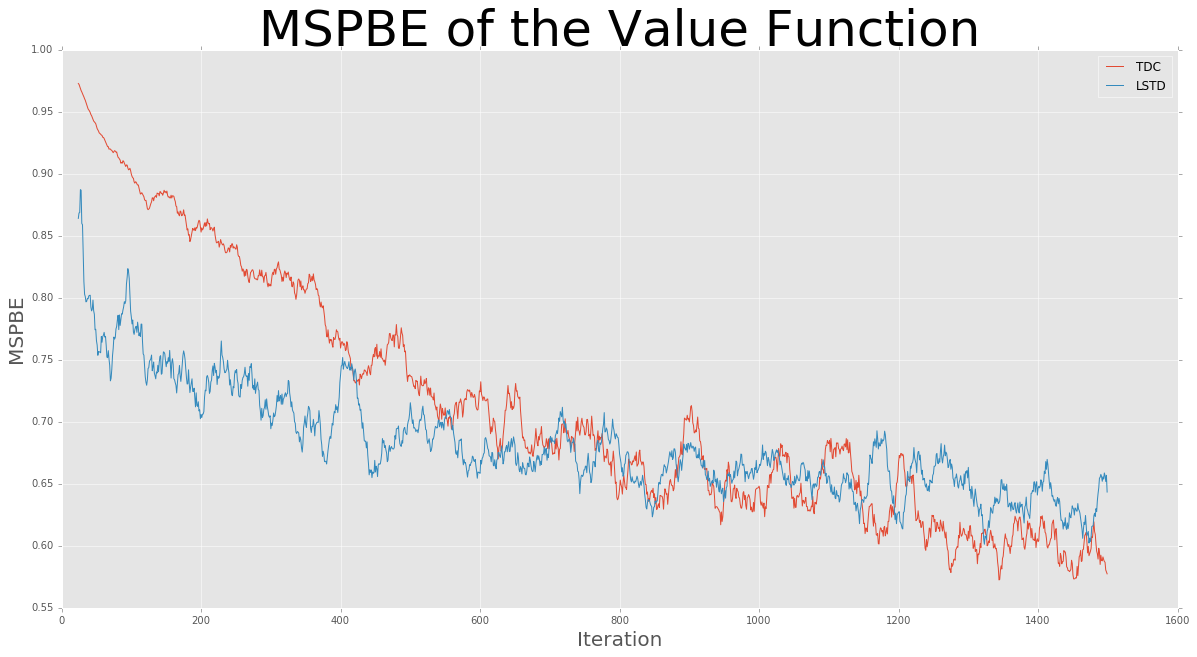

In [14]:
fig = plt.figure(figsize=(20, 10))

CE, = plt.plot(pd.rolling_mean(np.sqrt(MSPBE_TDC),25), label="TDC")
MC, = plt.plot(pd.rolling_mean(np.sqrt(MSPBE_LSTD),25), label="LSTD")

plt.title("MSPBE of the Value Function", fontsize=50)
ax = fig.add_subplot(111)
ax.set_xlabel('Iteration',fontsize = 20)
ax.set_ylabel('MSPBE', fontsize = 20)

plt.legend(handles=[CE, MC])
plt.show()